In [3]:
%load_ext autoreload
%autoreload 2

In [22]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import (
    BrownianProcess, BrownianAuxProcess, BrownianBridgeProcess,
    OUProcess, OUAuxProcess, OUBridgeProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLPSmall
from neuralbridge.models.neurb import NeuralBridge
from neuralbridge.utils.plotting import plot_sample_path, plot_sample_path_histogram

# Guiding Brownian bridge with another Brownian process
We use a Brownian bridge with constant drift as the target bridge, and approximate it by learning from another Brownian bridge without drift, specifically:
$$
\mathrm{d}X_t = \gamma\mathrm{d}t + \sigma\mathrm{d}W_t \\
\mathrm{d}X^{\star}_t = \left\{\gamma + \frac{v - X^{\star}_t - \gamma * (T - t)}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t = \left\{\frac{v - X^{\star}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
And the auxiliary and guided processes are:
$$
\mathrm{d}\tilde{X}_t = \sigma\mathrm{d}W_t \\
\mathrm{d}X^{\circ}_t = \left\{\gamma + \frac{v - X^{\circ}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Therefore, if the neural guided process is constructed as:
$$
\mathrm{d}X^{\diamond}_t = \left\{\gamma + \frac{v - X^{\circ}_t}{T-t} + \sigma\nu_{\theta}(t, X^{\diamond}_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
We can expect:
$$
\nu_{\theta^*}(t, x) = -\frac{\gamma}{\sigma}
$$

In [4]:
dim = 1
T = 1.0
dt = 1. / 250

params_X = {  
    "gamma": 1.0,
    "sigma": 1.0,
}
params_X_tilde = {
    "gamma": 0.0,
    "sigma": 1.0,
}

seed = 42
u = jnp.array([0.0])
v = jnp.array([0.0])

In [11]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

X = BrownianProcess(params_X, T, dim)
X_tilde = BrownianAuxProcess(params_X_tilde, T, dim)
X_star = BrownianBridgeProcess(params_X, v, T, dim)

X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    L0=jnp.eye(dim),
    Sigma0=jnp.eye(dim) * 1e-10,
    ts=jnp.arange(0, T + dt, dt),
    ode_solver_kernel=ode_solver_kernel
)

In [23]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(20, 20, 20),
    activation="tanh"
)

In [27]:
train_config = {
    "save_name": "brownian_bridge",
    "seed": seed,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "n_iters": 200,
    "n_epochs": 5,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [28]:
neural_bridge = NeuralBridge(X_circ, neural_net, train_config)

In [29]:
W = WienerProcess(T, dt, shape=(dim, ))
neural_bridge.initialize_path_solver(W)
losses = neural_bridge.train(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: 0.61921
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge/epoch_1


Epoch 2:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: 0.52768
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge/epoch_2


Epoch 3:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: 0.50531
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge/epoch_3


Epoch 4:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: 0.51364
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge/epoch_4


Epoch 5:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: 0.50872
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge/epoch_5


<Axes: title={'center': 'Brownian Bridges'}, xlabel='$t$', ylabel='$x$'>

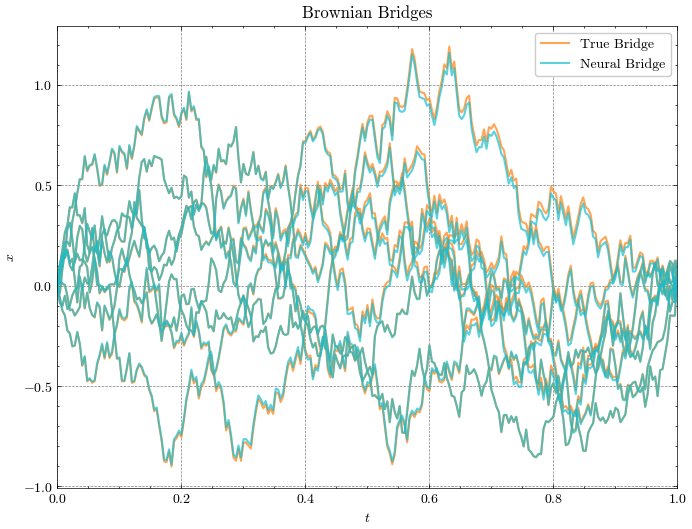

In [30]:
X_diamond_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=8)

true_bridge = Euler(X_star, W)
X_star_path = true_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=8)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_sample_path(X_star_path, ax=ax, color="tab:orange", label="True Bridge", linewidth=1.5)
plot_sample_path(X_diamond_path, ax=ax, color="tab:cyan", label="Neural Bridge", linewidth=1.5, title="Brownian Bridges")

# Guiding OU bridge with a Brownian process
We then use a standard Brownian motion as the auxiliary process to approach the Ornstein–Uhlenbeck bridge, specifically:
$$
\mathrm{d}X_t = -\gamma \cdot X_t \mathrm{d}W_t + \sigma \mathrm{d}W_t \\
\mathrm{d}X^{\star}_t = -\gamma\left[\frac{v}{\sinh(-\gamma(T-t))} - \frac{X^{\star}_t}{\tanh(-\gamma(T-t))}\right]\mathrm{d}t + \sigma\mathrm{d}W_t
$$
See _Constraint Ornstein-Uhlenbeck bridges, Alain Mazzolo_ for derived OU bridge. Then we choose a Brownian motion as the auxiliary process:
$$
\mathrm{d}\tilde{X}_t = \sigma \mathrm{d}W_t \\
\mathrm{d}X^{\circ}_t = \left\{-\gamma\cdot X^{\circ}_t + \frac{v-X^{\circ}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Therefore, if the neural guided process is constructed as:
$$
\mathrm{d}X^{\diamond}_t = \left\{-\gamma\cdot X^{\diamond}_t +\frac{v - X^{\diamond}_t}{T-t} + \sigma\nu_{\theta}(t, X^{\diamond}_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
We can expect:
$$
\nu_{\theta^*}(t, x) = \frac{1}{\sigma}\left\{-\gamma\left[\frac{v}{\sinh(-\gamma(T-t))} - \frac{x}{\tanh(-\gamma(T-t))}\right] - \frac{v-x}{T-t} + \gamma\cdot x\right\}
$$

In [142]:
dim = 1
T = 1.0
dt = 1. / 250

params_X = {  
    "gamma": 1.0,
    "sigma": 1.0,
}
params_X_tilde = {
    "gamma": 10.0,
    "sigma": 1.0,
}

seed = 42
u = jnp.array([0.0])
v = jnp.array([1.0])

In [143]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

X = OUProcess(params_X, T, dim)
X_tilde = OUAuxProcess(params_X_tilde, T, dim)
X_star = OUBridgeProcess(params_X, v, T, dim)

X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    L0=jnp.eye(dim),
    Sigma0=jnp.eye(dim) * 1e-10,
    ts=jnp.arange(0, T + dt, dt),
    ode_solver_kernel=ode_solver_kernel
)

In [144]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(20, 20, 20),
    activation="tanh"
)

In [145]:
train_config = {
    "save_name": "ou_bridge_10gamma",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 64,
    "n_iters": 500,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 300
}

In [146]:
neural_bridge = NeuralBridge(X_circ, neural_net, train_config)

In [147]:
W = WienerProcess(T, dt, shape=(dim, ))
neural_bridge.initialize_path_solver(W)
losses = neural_bridge.train(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -42.40635
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_10gamma/epoch_1


Epoch 2:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -57.82433
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_10gamma/epoch_2


Epoch 3:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -59.24434
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_10gamma/epoch_3


Epoch 4:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -59.41212
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_10gamma/epoch_4


Epoch 5:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -59.42805
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_10gamma/epoch_5


Epoch 6:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -59.31906
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_10gamma/epoch_6


Epoch 7:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -59.28053
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_10gamma/epoch_7


Epoch 8:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -59.33588
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_10gamma/epoch_8


Epoch 9:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -59.33319
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_10gamma/epoch_9


Epoch 10:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -59.31917
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_10gamma/epoch_10


<Axes: xlabel='$t$', ylabel='$X_t$'>

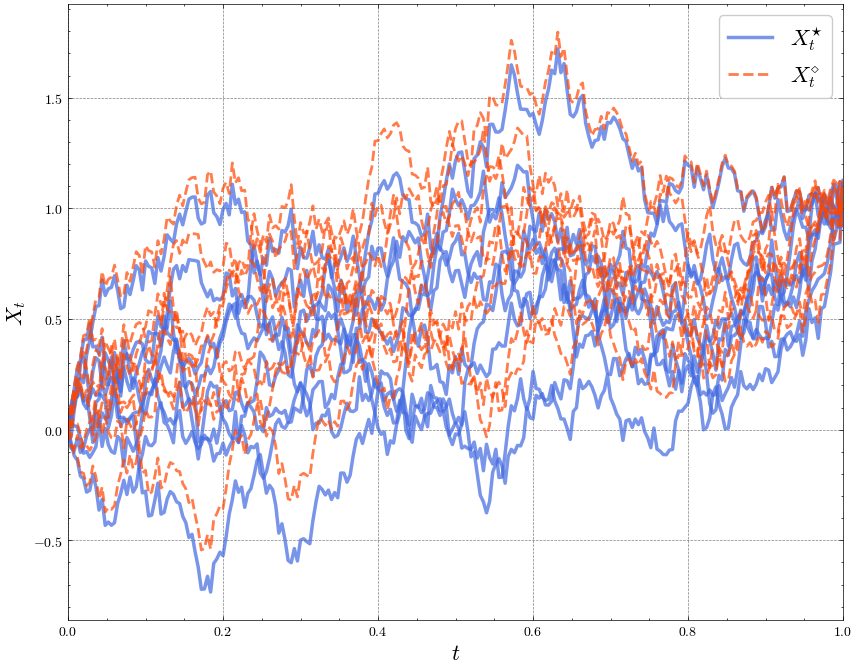

In [148]:
X_diamond_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=8)

true_bridge = Euler(X_star, W)
X_star_path = true_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=8)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_sample_path(X_star_path, ax=ax, color="royalblue", label=r"$X^{\star}_t$", linewidth=2.5)
plot_sample_path(X_diamond_path, ax=ax, color="orangered", label=r"$X^{\diamond}_t$", linewidth=2.0, linestyle="--")
# fig.savefig("../assets/figures/ou_bridge_vis.pdf", dpi=300)

In [149]:
X_diamond_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=1000)
X_star_path = true_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=1000)

ts = X_diamond_path.ts
X_diamond_xs = X_diamond_path.xs
X_star_xs = X_star_path.xs

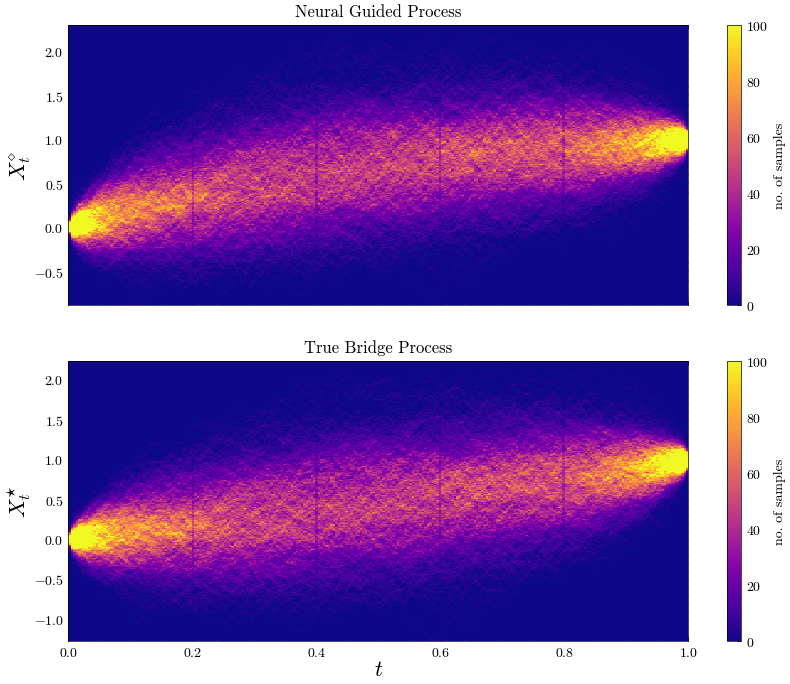

In [150]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plot_sample_path_histogram(X_diamond_path, ax=ax[0], plot_dim=0, vertical_bins=250, norm="linear", title="Neural Guided Process")
plot_sample_path_histogram(X_star_path, ax=ax[1], plot_dim=0, vertical_bins=250, norm="linear", title="True Bridge Process")

ax[0].set_ylabel(r'$X^{\diamond}_t$', fontsize=16, labelpad=0.5)
ax[1].set_xlabel(r'$t$', fontsize=16, labelpad=0.5)
ax[1].set_ylabel(r'$X^{\star}_t$', fontsize=16, labelpad=0.5)
plt.show()
# fig.savefig("../assets/figures/ou_bridge_histogram.pdf", dpi=300)

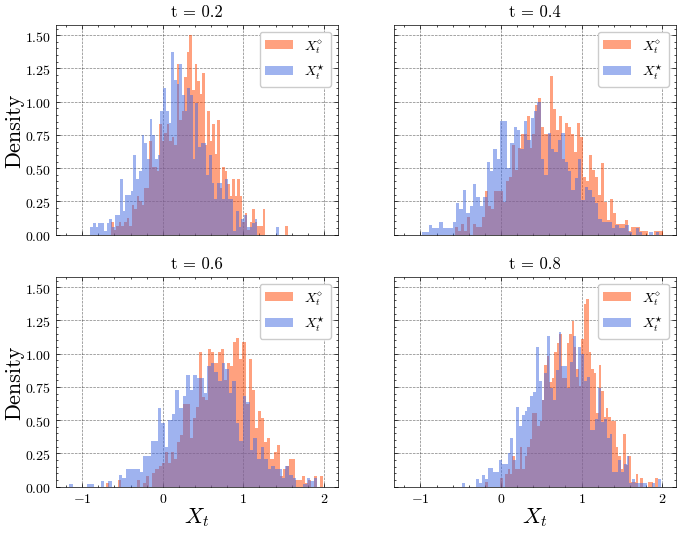

In [151]:
t_slices = [0.2, 0.4, 0.6, 0.8]

fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
for i, t_slice in enumerate(t_slices):
    t_idx = jnp.argmin(jnp.abs(ts - t_slice * T))
    ax[i // 2, i % 2].hist(X_diamond_xs[:, t_idx, 0], bins=70, density=True, color="orangered", alpha=0.5, label=r"$X^{\diamond}_t$")
    ax[i // 2, i % 2].hist(X_star_xs[:, t_idx, 0], bins=70, density=True, color="royalblue", alpha=0.5, label=r"$X^{\star}_t$")
    ax[i // 2, i % 2].set_title(f"t = {t_slice}")
    ax[i // 2, i % 2].legend()

ax[0, 0].set_ylabel(r'Density', fontsize=16, labelpad=0.5)
ax[1, 0].set_ylabel(r'Density', fontsize=16, labelpad=0.5)
ax[1, 0].set_xlabel(r'$X_t$', fontsize=16, labelpad=0.5)
ax[1, 1].set_xlabel(r'$X_t$', fontsize=16, labelpad=0.5)
plt.show()
# fig.savefig("../assets/figures/ou_bridge_histogram_slices.pdf", dpi=300)

In [152]:
import numpy as np

(0.0, 1.0)

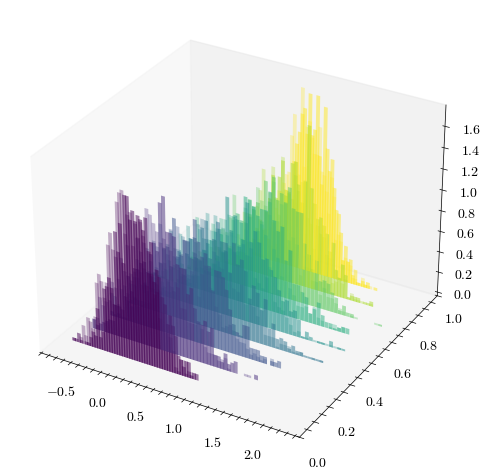

In [153]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

y_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = plt.cm.viridis(np.linspace(0, 1, len(y_ticks)))

for c, k in zip(colors, y_ticks):
    # Find the index corresponding to time k*T
    t_idx = jnp.argmin(jnp.abs(ts - k*T))
    
    # Get samples at this time point
    diamond_samples = X_diamond_xs[:, t_idx, 0]
    star_samples = X_star_xs[:, t_idx, 0]
    
    # Create histogram for both processes at this time slice
    hist_diamond, bins = np.histogram(diamond_samples, bins=50, density=True)
    hist_star, _ = np.histogram(star_samples, bins=bins, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot histograms on the corresponding plane
    zs = k * np.ones_like(bin_centers)
    ax.bar(bin_centers, hist_diamond, zs=zs, zdir='y', color=c, alpha=0.5, width=0.05, fill=True)
    ax.bar(bin_centers, hist_star, zs=zs, zdir='y', color=c, alpha=0.3, width=0.05, fill=True)
    
ax.grid(False)
ax.set_ylim(0.0, 1.0)


In [165]:
def ou_transition(t, x_t, s, x_s, gamma, sigma):
    D = sigma ** 2 / 2.0
    exponential = jnp.exp(-gamma * (t - s + 1e-8))
    normalization = jnp.sqrt(gamma / (2. * jnp.pi * D * (1 - exponential ** 2)))
    return normalization * jnp.exp(-gamma * (x_t - x_s * exponential) ** 2 / (2. * D * (1 - exponential ** 2)))

def optimal_loss(gamma, sigma):
    true_bridge_transition = ou_transition(1.0, 1.0, 0.0, 0.0, 1.0, sigma)
    guided_bridge_transition = ou_transition(1.0, 1.0, 0.0, 0.0, gamma, sigma)
    return jnp.log(guided_bridge_transition) - jnp.log(true_bridge_transition)


In [166]:
for gamma in [0.0, 1.0, 2.0, 5.0, 10.0]:
    print(f"gamma = {gamma}")
    print(f"Optimal loss: {optimal_loss(gamma, 1.0)}")

gamma = 0.0
Optimal loss: nan
gamma = 1.0
Optimal loss: 0.0
gamma = 2.0
Optimal loss: -0.5976874828338623
gamma = 5.0
Optimal loss: -3.1116745471954346
gamma = 10.0
Optimal loss: -7.764896392822266


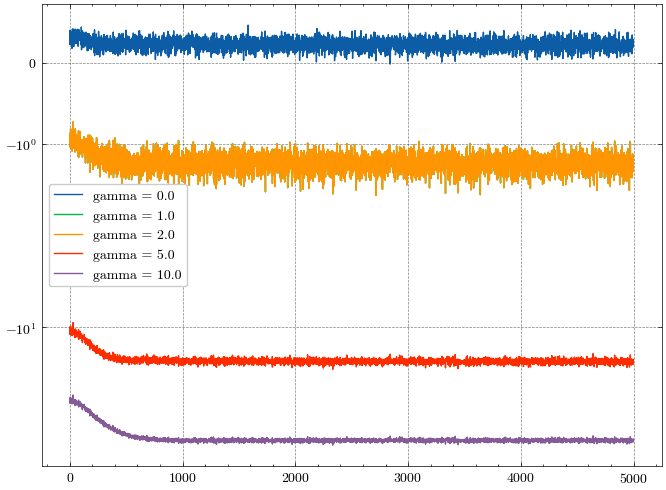

In [160]:
loss0 = jnp.load("../assets/ckpts/neuralbridge/ou_bridge_0gamma/losses.npy")
loss1 = jnp.load("../assets/ckpts/neuralbridge/ou_bridge_1gamma/losses.npy")
loss2 = jnp.load("../assets/ckpts/neuralbridge/ou_bridge_2gamma/losses.npy")
loss5 = jnp.load("../assets/ckpts/neuralbridge/ou_bridge_5gamma/losses.npy")
loss10 = jnp.load("../assets/ckpts/neuralbridge/ou_bridge_10gamma/losses.npy")

plt.figure(figsize=(8, 6))
plt.plot(loss0, label="gamma = 0.0")
plt.plot(loss1, label="gamma = 1.0")
plt.plot(loss2, label="gamma = 2.0")
plt.plot(loss5, label="gamma = 5.0")
plt.plot(loss10, label="gamma = 10.0")
plt.yscale("symlog")
plt.legend()
plt.show()

